In [1]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import os
import PIL # for reading tif images
import h5py
import datetime as dt
import time
import sys
from scipy.optimize import curve_fit, fsolve

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3
us = 1e-6
kHz = 1e3
kB = 1.38e-23
mRb = 1.443160817941e-25

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## predicted trap frequencies

In [ ]:
w0 = 0.7e-6
lmbda = 8.52e-7
zR = np.pi*w0**2/lmbda
Tfort = 2.5e-3
U0 = kB*Tfort
fr = (2/w0)*np.sqrt(U0/mRb)/(2*np.pi)
fz = (1/zR)*np.sqrt(2*U0/mRb)/(2*np.pi)
print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")

In [2]:
w0 = 0.7e-6
lmbda = 8.52e-7
zR = np.pi*w0**2/lmbda
Tfort = 1e-3
U0 = kB*Tfort
fr = (2/w0)*np.sqrt(U0/mRb)/(2*np.pi)
fz = (1/zR)*np.sqrt(2*U0/mRb)/(2*np.pi)
print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")

radial freq. 140.61584658593725 kHz
axial freq. 38.522188330290135 kHz


## 2024.06.28
As of today, the Rigol DG1022Z is configured over VISA for maximum reproduceability

In [2]:
fnames = get_files_by_criteria(date_filters=["2024-06-28"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))

        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            # if "GeneralVariableScan" in f:
            try:
                scan_str = str_from_h5(ds['scan_variable1_name'])
                if str_from_h5(ds['scan_variable2_name']) != '':
                    scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                print(f"file {i} ({f}) scanned over "+scan_str)
            except:
                print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
print(f"skipped {len(fnames)-len(rid_list)} redundant files")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\09\000015417-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\09\000015418-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\09\000015419-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\09\000015420-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\13\000015436-GeneralVariableScan.h5) scanned over Rigol_carrier_frequency
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\13\000015437-GeneralVariableScan.h5) scanned over Rigol_carrier_frequency
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-28\13\000015446-GeneralVa

### trap frequency scans
For the scans below, the Rigol DG1022Z was used to provide modulation on a dc bias sent to a VCA to modulate the FORT AOM RF. By using an RF switch in reverse, the Rigol modulation + dc was sent into one RF port, and a dc value from Zotino on the other port, such that modulation and static traps can be switched between using the switch's TTL input.

experiment: trap_frequency_experiment
carrier: 0.05 FM dev: 0.595
experiment: trap_frequency_experiment
carrier: 0.05 FM dev: 0.595
experiment: trap_frequency_experiment
carrier: 0.02 FM dev: 0.595
experiment: trap_frequency_experiment
carrier: 0.02 FM dev: 0.595


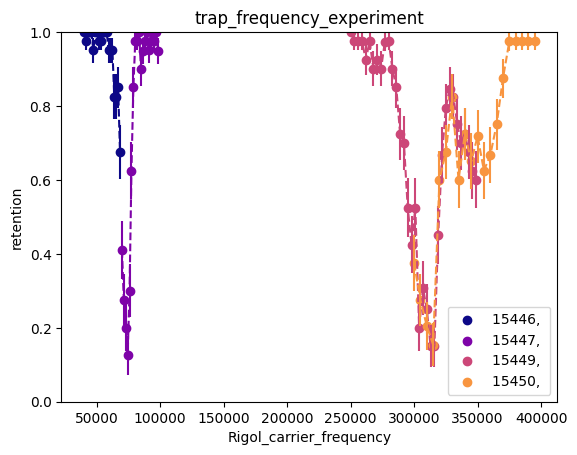

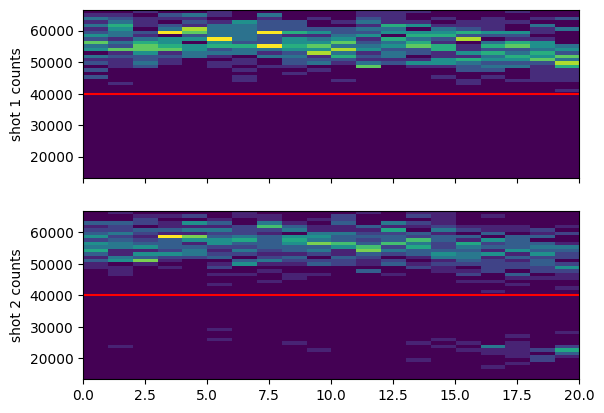

In [4]:
compare = True # compare multiple files in the same retention and loading plots

# blow-away is working but ther's some kind of bug such that the t_blowaway variable seems to be ignored. 
file_indices = {
    # 5: '', # clear axial resonance :D. 50 mVpp modulation + 595 mVdc on Rigol
    6: '',
    8: '', # radial resonance, still broad :D. 30 mVpp modulation + 595 mVdc on Rigol
    10: '', # radial resonance, still broad :D. 20 mVpp modulation + 595 mVdc on Rigol
    12: ''
} # the files to plot

 # for all of the files plotted, combine the data so we can do one fit for both dips
combined_retention = []
combined_errs = []
combined_frequencies = []

custom_xlabel = False
# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

if custom_xlabel:
    xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

showhist = True
showloading = False

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['plasma']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = [] # shot 1 mean background count rate
mean2_by_iteration = [] # shot 2 mean background count rate
mean_photons2_by_iteration = [] # shot 2 mean total counts
mean_bg2_by_iteration = [] # shot 2 mean background counts
photocounts2_by_measurement = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("carrier:",Rigol_V_pp,"FM dev:",Rigol_V_DC)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 40000*t_SPCM_first_shot

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    mean_photons2_by_iteration += [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements]
                                          [photocounts2[i*n_measurements:(i+1)*n_measurements] > cutoff2]) 
                              for i in range(iterations)]
    mean_bg2_by_iteration += [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements]
                                          [photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]) 
                              for i in range(iterations)]

    # print(photocounts2.shape)
    photocounts2_by_measurement += list(photocounts2)
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    combined_retention += list(retention_array)
    combined_frequencies += list(scan_sequence1)
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        # errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        errs = binomial_err(n_loaded, retention)
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        combined_errs += list(errs)

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            # errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            errs = binomial_err(n_loaded, loading)

            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)

combined_frequencies = np.array(combined_frequencies)
if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

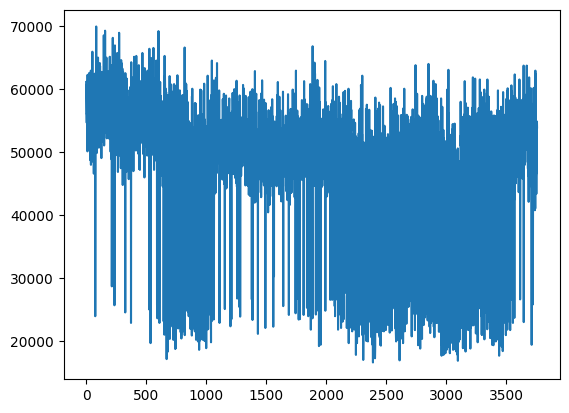

In [230]:
plt.plot(np.array(photocounts2_by_measurement)/t_SPCM_second_shot)

In [232]:
np.nan in photocounts2_by_measurement

False

In [239]:
iterations = int(len(photocounts2_by_measurement)/n_measurements)
iterations

94

In [245]:
cps_by_measurement = np.array(photocounts2_by_measurement)/t_SPCM_second_shot
bg_cps_by_iteration = [np.mean(cps_by_measurement[i*n_measurements:(i+1)*n_measurements][
    cps_by_measurement[i*n_measurements:(i+1)*n_measurements] < 40000]) for i in range(iterations)] 
signal_cps_by_iteration = [np.mean(cps_by_measurement[i*n_measurements:(i+1)*n_measurements][
    cps_by_measurement[i*n_measurements:(i+1)*n_measurements] > 40000]) for i in range(iterations)]

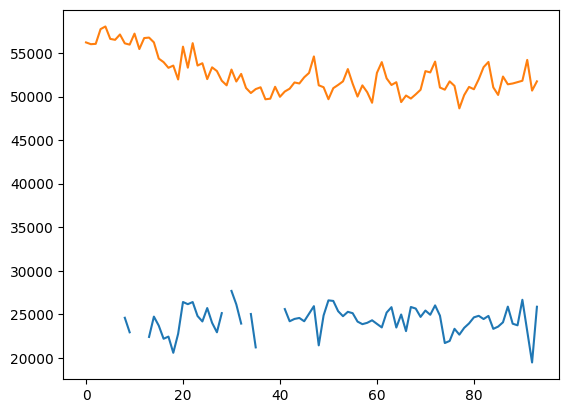

In [247]:
# plt.plot(cps_by_measurement)
plt.plot(bg_cps_by_iteration)
plt.plot(signal_cps_by_iteration)

Text(0, 0.5, 'counts/s')

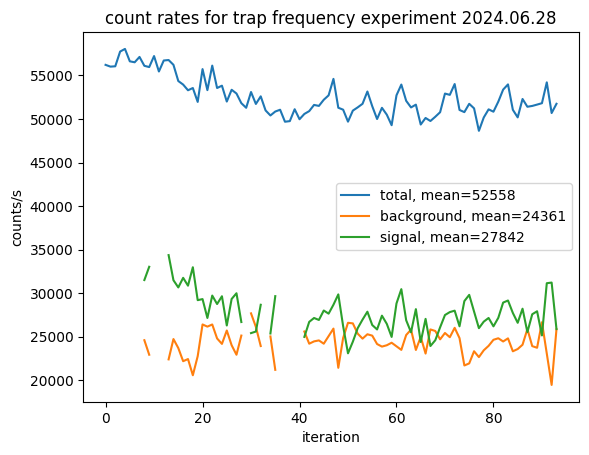

In [248]:
mean_total_cps = np.array(mean_photons2_by_iteration)/t_SPCM_first_shot
mean_bg_cps = np.array(mean_bg2_by_iteration)/t_SPCM_first_shot
mean_signal_cps = mean_total_cps - mean_bg_cps

plt.plot(mean_total_cps, label=f'total, mean={np.mean(mean_total_cps):.0f}')
plt.plot(mean_bg_cps, label=f'background, mean={np.nanmean(mean_bg_cps):.0f}')
plt.plot(mean_signal_cps, label=f'signal, mean={np.nanmean(mean_signal_cps):.0f}')
plt.title("count rates for trap frequency experiment 2024.06.28")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("counts/s")

sanity check
[-13946.558112105035, 1878.3686803104792]
[ True  True]
radial freq. 154.5624046980423 kHz
axial freq. 36.643819649979655 kHz
waist w0 = 0.81 um
trap depth T = 1.6 mK


Text(0.5, 0, 'modulation frequency (kHz)')

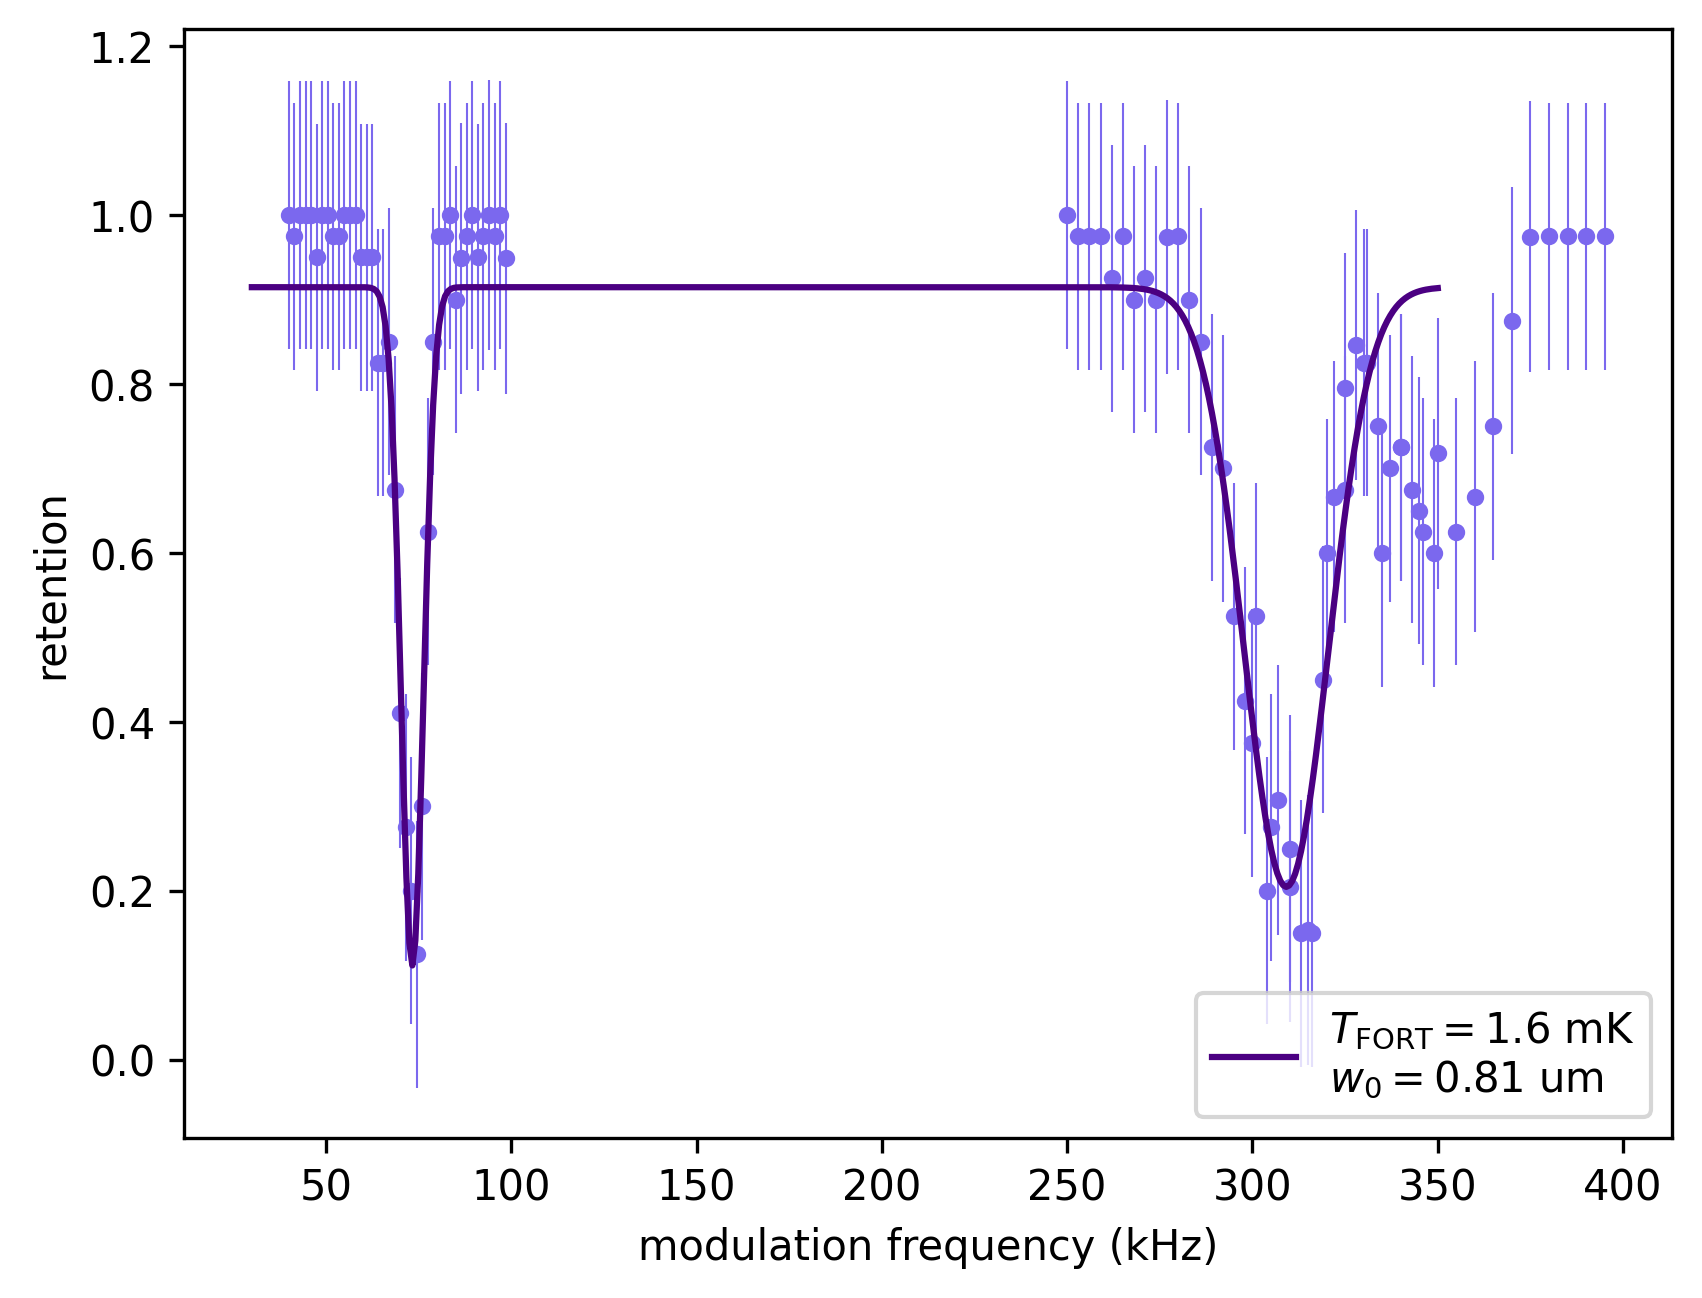

In [125]:
fig,ax = plt.subplots(dpi=300)
ax.scatter(combined_frequencies*1e-3, combined_retention,color='mediumslateblue',zorder=1,s=10)
ax.errorbar(combined_frequencies*1e-3, combined_retention, combined_errs,color='mediumslateblue',zorder=1,lw=0.5,ls='none')

model = lambda f,r,ar,az,fr,fz,sr,sz: r - ar*np.exp(-((f-2*fr)/sr)**2) - az*np.exp(-((f-2*fz)/sz)**2)

f_list = np.linspace(30000,350000,400)
guess = [1,0.9,0.8,155e3,37e3,5e3,15e3]
# ax.plot(f_list,model(f_list,*guess)) # check my guess
popt, pcov = curve_fit(model, combined_frequencies, combined_retention, p0=guess)
r,ar,az,fr,fz,sr,sz = popt

lmbda = 8.52e-7

def func(x):
    w0, TFORT = x
    zR = np.pi*w0**2/lmbda
    U0 = kB*TFORT
    
    # [radial eq = 0, axial eq = 0]
    return [(2/w0)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr, (1/zR)*np.sqrt(2*kB*TFORT/mRb)/(2*np.pi) - fz]

print("sanity check")
initial_guess = [0.7e-6, 1e-3]
print(func(initial_guess))

initial_guess = [0.7e-6, 1e-3]
w0, TFORT = fsolve(func, initial_guess)

# verify solution
print(np.isclose(func([w0, TFORT]), [0.0,0.0]))

print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")
print(f"waist w0 = {w0*1e6:.2} um")
print(f"trap depth T = {TFORT*1e3:.2} mK")

ax.plot(f_list*1e-3,model(f_list,*popt),color='indigo',zorder=3, label=r"$T_{\rm FORT}=$"+f"{TFORT*1e3:.2} mK \n"+r"$w_0=$"+f"{w0*1e6:.2} um")
ax.legend(loc='lower right')
ax.set_ylabel("retention")
ax.set_xlabel("modulation frequency (kHz)")

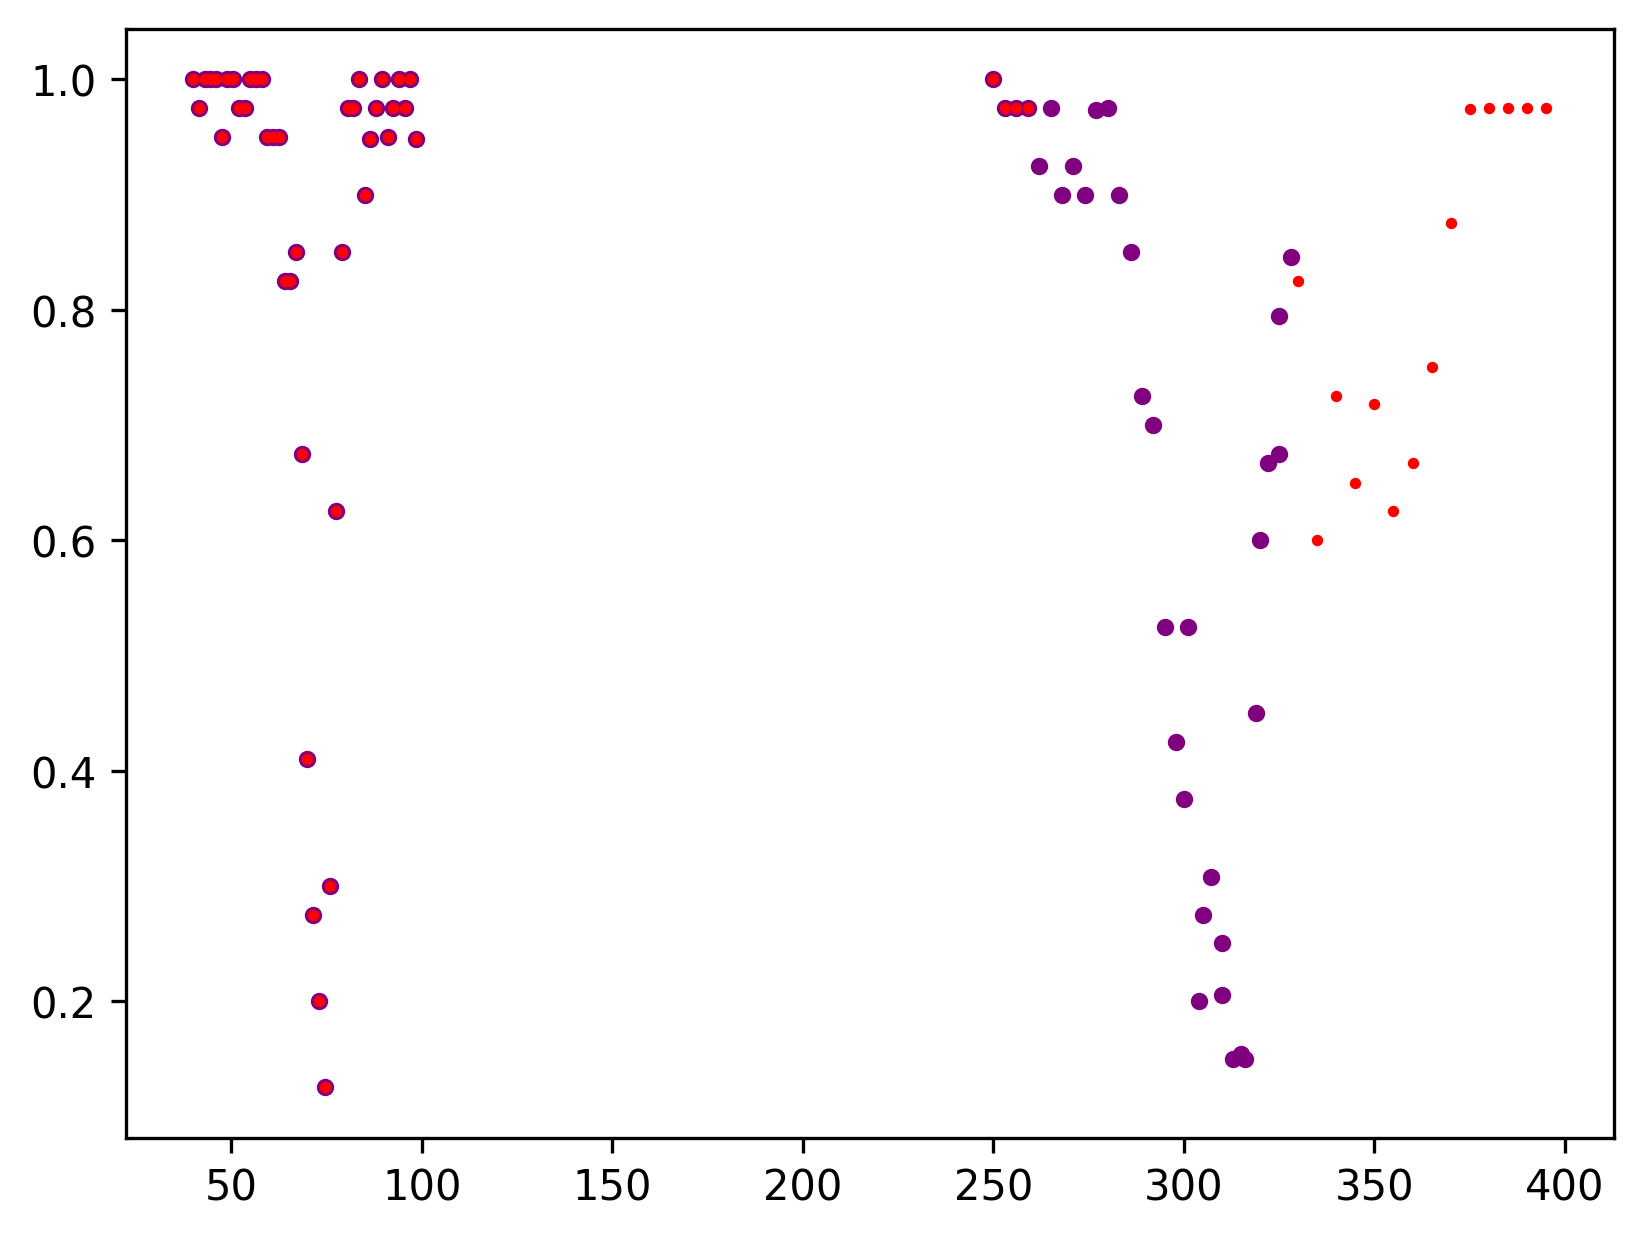

In [162]:
fig,ax = plt.subplots(dpi=300)
strt = 0
stp = 44 #67
# ax.scatter(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], color='mediumslateblue',zorder=1,s=10)
# ax.errorbar(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], combined_errs[strt:stp], color='mediumslateblue',zorder=1,lw=0.5,ls='none')

# strt = 80
# stp = -1
# ax.scatter(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], color='red',zorder=1,s=10)
# ax.errorbar(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], combined_errs[strt:stp], color='red',zorder=1,lw=0.5,ls='none')

# strt = 74
# stp = 80
# ax.scatter(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], color='orange',zorder=1,s=10)
# ax.errorbar(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], combined_errs[strt:stp], color='orange',zorder=1,lw=0.5,ls='none')

# strt = 67
# stp = 74
# ax.scatter(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], color='purple',zorder=1,s=10)
# ax.errorbar(combined_frequencies[strt:stp]*1e-3, combined_retention[strt:stp], combined_errs[strt:stp], color='purple',zorder=1,lw=0.5,ls='none')

combined_frequencies1 = np.array(list(combined_frequencies[:67]) + list(combined_frequencies[74:80]))
combined_retention1 = np.array(list(combined_retention[:67]) + list(combined_retention[74:80]))

combined_frequencies2 = np.array(list(combined_frequencies[:44]) + list(combined_frequencies[80:]))
combined_retention2 = np.array(list(combined_retention[:44]) + list(combined_retention[80:]))

ax.scatter(combined_frequencies1*1e-3, combined_retention1, color='purple',zorder=1,s=10)
ax.scatter(combined_frequencies2*1e-3, combined_retention2, color='red',zorder=1,s=3)

sanity check
[-13753.552661561494, 1902.4147629654399]
[ True  True]
radial freq. 154.36939924749876 kHz
axial freq. 36.61977356732469 kHz
waist w0 = 0.81 um
trap depth T = 1.6 mK
sanity check
[-33014.38007824568, 1906.1573142395791]
[ True  True]
radial freq. 173.63022666418294 kHz
axial freq. 36.616031016050556 kHz
waist w0 = 0.91 um
trap depth T = 2.6 mK


Text(0.5, 0, 'modulation frequency (kHz)')

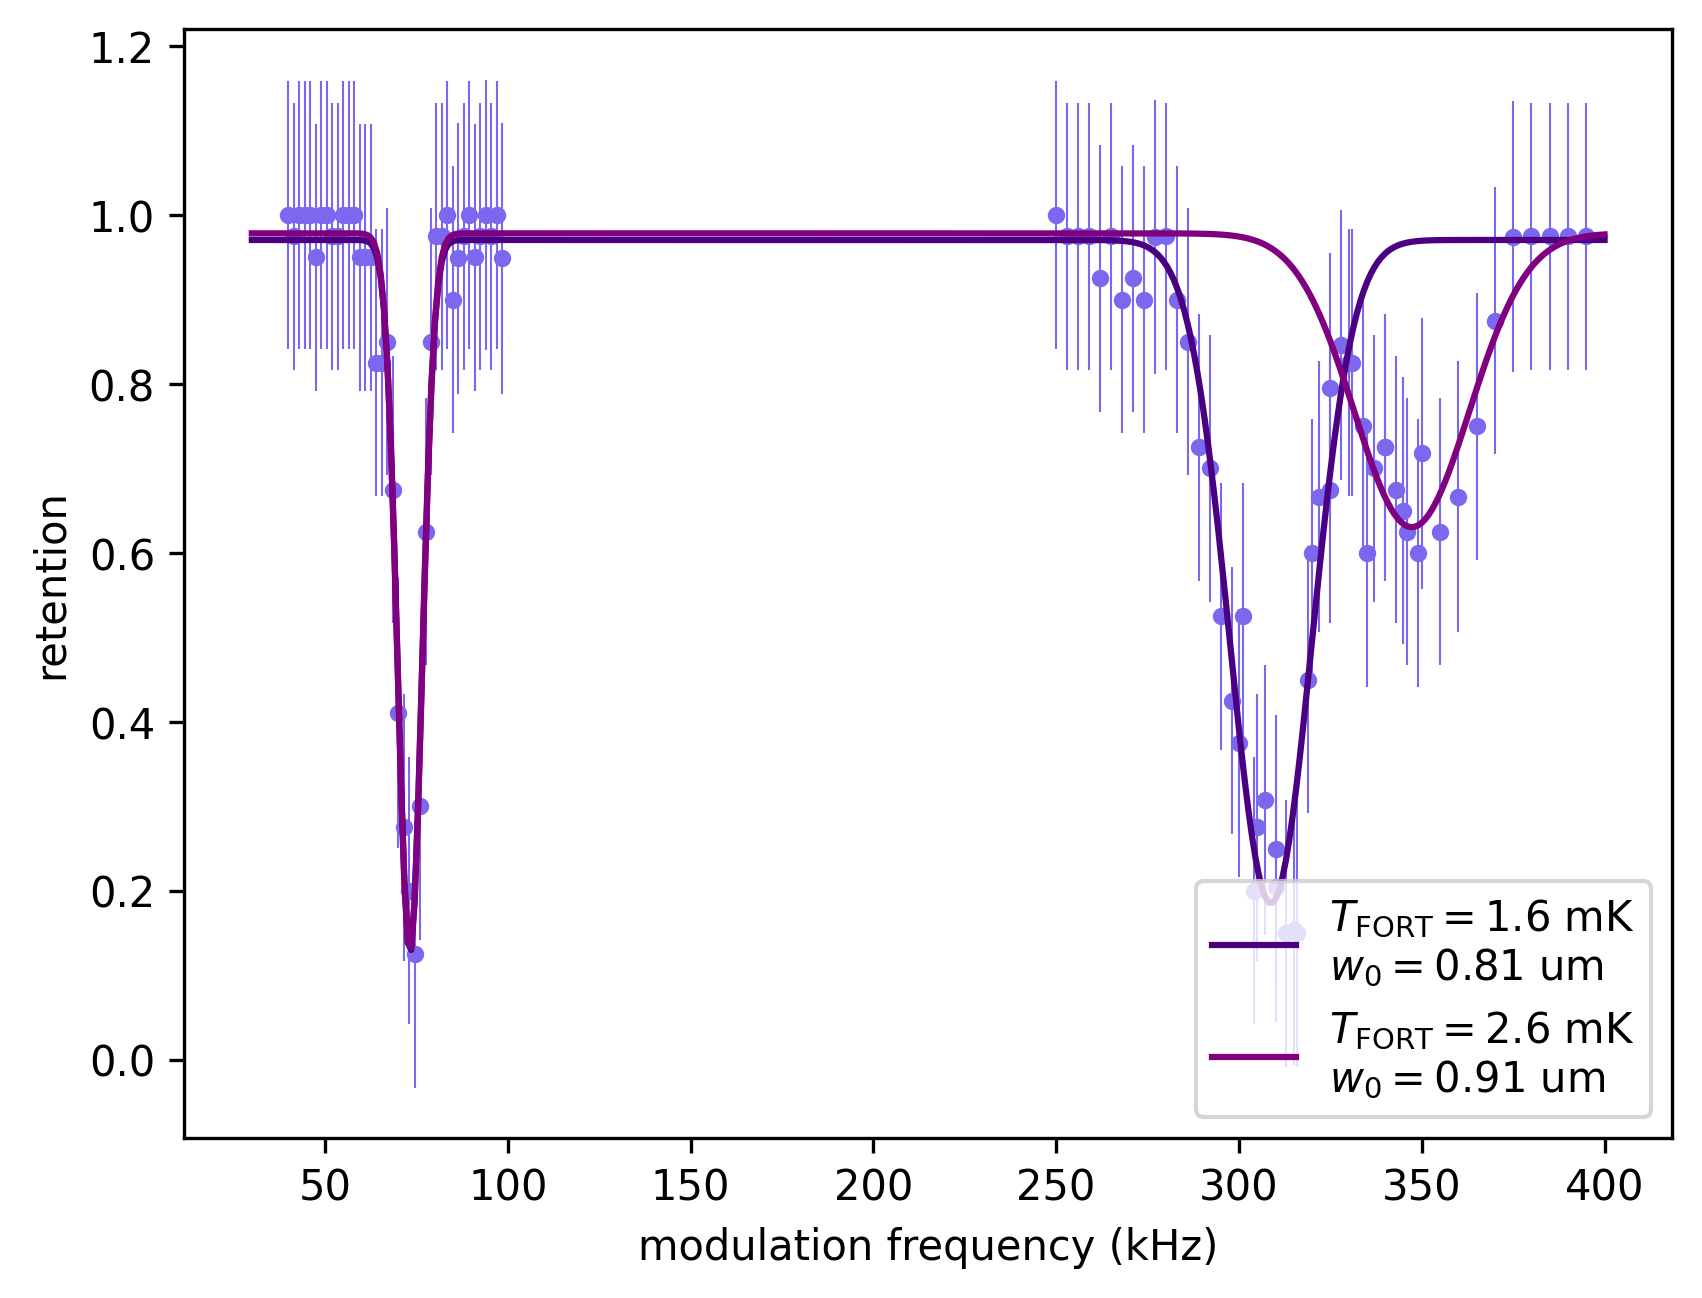

In [167]:
# try to fit the two sets of dips independently

fig,ax = plt.subplots(dpi=300)
ax.scatter(combined_frequencies*1e-3, combined_retention,color='mediumslateblue',zorder=1,s=10)
ax.errorbar(combined_frequencies*1e-3, combined_retention, combined_errs,color='mediumslateblue',zorder=1,lw=0.5,ls='none')

model = lambda f,r,ar,az,fr,fz,sr,sz: r - ar*np.exp(-((f-2*fr)/sr)**2) - az*np.exp(-((f-2*fz)/sz)**2)

f_list = np.linspace(30000,400000,400)

# fit the axial and first radial dip
guess = [1,0.9,0.8,155e3,37e3,5e3,15e3]
# ax.plot(f_list,model(f_list,*guess)) # check my guess
popt, pcov = curve_fit(model, combined_frequencies1, combined_retention1, p0=guess)
r,ar,az,fr,fz,sr,sz = popt

# solve for the trap parameters using the trap frequencies from the fit
lmbda = 8.52e-7

def func(x):
    w0, w02, TFORT = x
    zR = np.pi*w0**2/lmbda
    U0 = kB*TFORT
    # [radial eq1 = 0, radial eq2 = 0, axial eq = 0]
    return [(2/w0)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr, (2/w02)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr2, (1/zR)*np.sqrt(2*kB*TFORT/mRb)/(2*np.pi) - fz]

print("sanity check")
initial_guess = [0.8e-6, 0.8e-6, 1e-3]
print(func(initial_guess))

initial_guess = [0.7e-6, 1e-3]
w0, w02, TFORT = fsolve(func, initial_guess)

# verify solution
print(np.isclose(func([w0, w02, TFORT]), [0.0,0.0,]))

print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")
print(f"waist w0 = {w0*1e6:.2} um")
print(f"trap depth T = {TFORT*1e3:.2} mK")

ax.plot(f_list*1e-3,model(f_list,*popt),color='indigo',zorder=3, label=r"$T_{\rm FORT}=$"+f"{TFORT*1e3:.2} mK \n"+r"$w_0=$"+f"{w0*1e6:.2} um")

# fit the axial and second radial dip
guess = [1,0.9,0.6,175e3,37e3,5e3,15e3]
# ax.plot(f_list,model(f_list,*guess)) # check my guess
popt, pcov = curve_fit(model, combined_frequencies2, combined_retention2, p0=guess)
r,ar,az,fr,fz,sr,sz = popt

lmbda = 8.52e-7

def func(x):
    w0, TFORT = x
    zR = np.pi*w0**2/lmbda
    U0 = kB*TFORT
    
    # [radial eq = 0, axial eq = 0]
    return [(2/w0)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr, (1/zR)*np.sqrt(2*kB*TFORT/mRb)/(2*np.pi) - fz]

print("sanity check")
initial_guess = [0.7e-6, 1e-3]
print(func(initial_guess))

initial_guess = [0.7e-6, 1e-3]
w0, TFORT = fsolve(func, initial_guess)

# verify solution
print(np.isclose(func([w0, TFORT]), [0.0,0.0]))

print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")
print(f"waist w0 = {w0*1e6:.2} um")
print(f"trap depth T = {TFORT*1e3:.2} mK")

ax.plot(f_list*1e-3,model(f_list,*popt),color='purple',zorder=4, label=r"$T_{\rm FORT}=$"+f"{TFORT*1e3:.2} mK \n"+r"$w_0=$"+f"{w0*1e6:.2} um")

ax.legend(loc='lower right')
ax.set_ylabel("retention")
ax.set_xlabel("modulation frequency (kHz)")

In [180]:
np.pi*0.8e-6**2/lmbda, np.pi*0.9e-6**2/lmbda

(2.3598818055134595e-06, 2.986725410102972e-06)

radial freq. 154.2549438143543 kHz
radial freq. 2 175.35793946129348 kHz
axial freq. 36.61982219398983 kHz
waist w0,1 = 0.91 um
waist w0,2 = 0.8 um
trap depth T = 2.1 mK
saved file to  trap_frequency_experiment 15450.svg


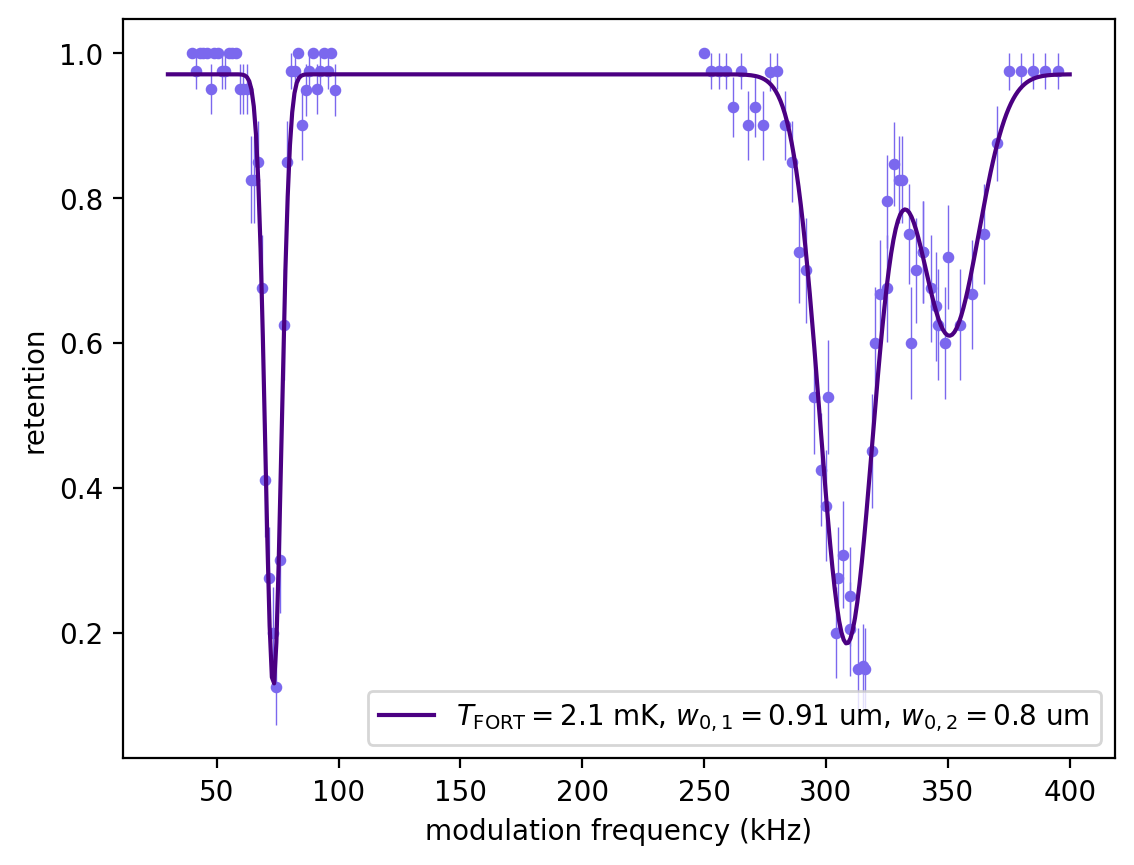

In [6]:
# fit all three dips (actually, there are four, but we can't resolve the two axial ones)

fig,ax = plt.subplots(dpi=200)
ax.scatter(combined_frequencies*1e-3, combined_retention,color='mediumslateblue',zorder=1,s=10)
ax.errorbar(combined_frequencies*1e-3, combined_retention, combined_errs,color='mediumslateblue',zorder=1,lw=0.5,ls='none')

model = lambda f,r,ar,ar2,az,fr,fr2,fz,sr2,sr,sz: r - ar*np.exp(-((f-2*fr)/sr)**2) - ar2*np.exp(-((f-2*fr2)/sr2)**2) - az*np.exp(-((f-2*fz)/sz)**2) #- az2*np.exp(-((f-2*fz2)/sz2)**2)

f_list = np.linspace(30000,400000,400)

# fit the axial and two radial dips
guess = [1,0.9,0.8,0.6,  # r,ar,ar2,az 
         155e3,175e3,37e3, # fr,fr2,fz
         10e3,10e3,5e3] # sr2,sr,sz

# ax.plot(f_list,model(f_list,*guess)) # check my guess
popt, pcov = curve_fit(model, combined_frequencies, combined_retention, p0=guess)
r,ar,ar2,az,fr,fr2,fz,sr2,sr,sz = popt

# solve for the trap parameters using the trap frequencies fz,fr from the fit
lmbda = 8.52e-7

def func(x):
    w0, w02, TFORT = x
    # zR = np.pi*w0**2/lmbda
    # zR = np.pi*w02**2/lmbda
    zR = np.pi*(0.5*(w02+w0))**2/lmbda
    U0 = kB*TFORT
    # [radial eq1 = 0, radial eq2 = 0, axial eq = 0]
    return [(2/w0)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr, (2/w02)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr2, (1/zR)*np.sqrt(2*kB*TFORT/mRb)/(2*np.pi) - fz]

initial_guess = [0.8e-6, 0.8e-6, 1.5e-3]
# print("sanity check")
# print(func(initial_guess))

w0, w02, TFORT = fsolve(func, initial_guess)

# verify solution
# assert np.product(np.isclose(func([w0, w02, TFORT]), [0]*3)), "bad solution"

print("radial freq.", fr*1e-3, "kHz")
print("radial freq. 2", fr2*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")
print(f"waist w0,1 = {w0*1e6:.2} um")
print(f"waist w0,2 = {w02*1e6:.2} um")
print(f"trap depth T = {TFORT*1e3:.2} mK")

ax.plot(f_list*1e-3,model(f_list,*popt),color='indigo',zorder=3, label=r"$T_{\rm FORT}=$"+f"{TFORT*1e3:.2} mK, "+r"$w_{0,1}=$"+f"{w0*1e6:.2} um, "+r"$w_{0,2}=$"+f"{w02*1e6:.2} um")

ax.legend(loc='lower right')
ax.set_ylabel("retention")
ax.set_xlabel("modulation frequency (kHz)")

# title = experiment_function+' '+str(rid)
# savename = title.replace(',','_') + '.svg'
# plt.savefig(savename, bbox_inches='tight')
# print("saved file to ", savename)

In [199]:
-4.815*2.1+0.584

-9.527500000000002

In [186]:
np.isclose(func([w0, w02, TFORT]), [0]*3)

array([False, False, False])

In [189]:
func([w0, w02, TFORT])

[-3.651977749541402e-06, 2.9627408366650343e-06, -1.2263190001249313e-06]

In [169]:
0.9/0.8, 0.75/0.7

(1.125, 1.0714285714285714)

In [100]:
fr, fz

(154563.82849627052, 36632.441571603624)

In [108]:
lmbda = 8.52e-7

def func(x):
    w0, TFORT = x
    zR = np.pi*w0**2/lmbda
    U0 = kB*TFORT
    
    # [radial eq = 0, axial eq = 0]
    return [(2/w0)*np.sqrt(kB*TFORT/mRb)/(2*np.pi) - fr, (1/zR)*np.sqrt(2*kB*TFORT/mRb)/(2*np.pi) - fz]

print("sanity check")
initial_guess = [0.7e-6, 1e-3]
print(func(initial_guess))

initial_guess = [0.7e-6, 1e-3]
w0, TFORT = fsolve(func, initial_guess)

# verify solution
assert np.isclose(func([w0, w02, TFORT]), [True]*3))

print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")
print(f"waist w0 = {w0*1e6:.2} um")
print(f"trap depth T = {TFORT*1e3:.2} mK")

sanity check
[-13947.98191033327, 1889.7467586865096]
[ True  True]
radial freq. 154.56382849627053 kHz
axial freq. 36.63244157160362 kHz
waist w0 = 0.81 um
trap depth T = 1.6 mK


## 2024.06.27
We found two clear dips! but the frequencies on the x axis are not reliable because of the non-linearity of conversion of modulation volts to output frequency on the Rigol. data as of 2024.06.28 used VISA to set the frequency of the Rigol which is much more reliable.

In [3]:
fnames = get_files_by_criteria(date_filters=["2024-06-27"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))

        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            # if "GeneralVariableScan" in f:
            try:
                scan_str = str_from_h5(ds['scan_variable1_name'])
                if str_from_h5(ds['scan_variable2_name']) != '':
                    scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                print(f"file {i} ({f}) scanned over "+scan_str)
            except:
                print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
print(f"skipped {len(fnames)-len(rid_list)} redundant files")

found 21 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015380-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015381-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015382-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015384-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015389-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\10\000015392-GeneralVariableScan.h5) scanned over f_Rigol_modulation
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-27\11\000015395-GeneralVariableScan

### trap frequency scans
For the scans below, the Rigol DG1022Z was used to provide modulation on a dc bias sent to a VCA to modulate the FORT AOM RF. By using an RF switch in reverse, the Rigol modulation + dc was sent into one RF port, and a dc value from Zotino on the other port, such that modulation and static traps can be switched between using the switch's TTL input.

experiment: trap_frequency_experiment
carrier: 65000.0 FM dev: 35000.0
frequency_steps: [ 30000.          32058.82352941  34117.64705882  36176.47058824
  38235.29411765  40294.11764706  42352.94117647  44411.76470588
  46470.58823529  48529.41176471  50588.23529412  52647.05882353
  54705.88235294  56764.70588235  58823.52941176  60882.35294118
  62941.17647059  65000.          67058.82352941  69117.64705882
  71176.47058824  73235.29411765  75294.11764706  77352.94117647
  79411.76470588  81470.58823529  83529.41176471  85588.23529412
  87647.05882353  89705.88235294  91764.70588235  93823.52941176
  95882.35294118  97941.17647059 100000.        ]
AY_volts_OP: 2.0
experiment: trap_frequency_experiment
carrier: 310000.0 FM dev: 30000.0
frequency_steps: [280000. 283000. 286000. 289000. 292000. 295000. 298000. 301000. 304000.
 307000. 310000. 313000. 316000. 319000. 322000. 325000. 328000. 331000.
 334000. 337000.]
AY_volts_OP: 2.0


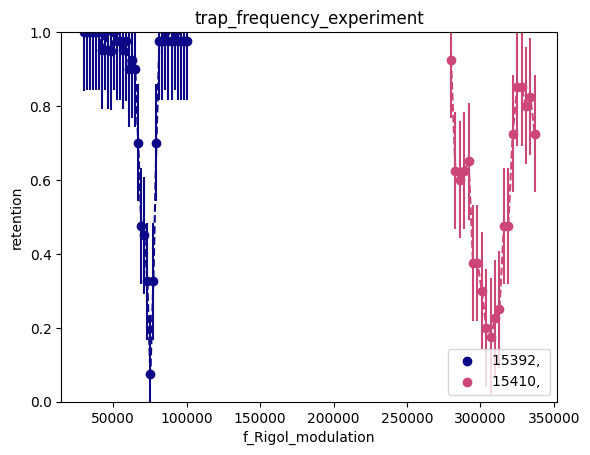

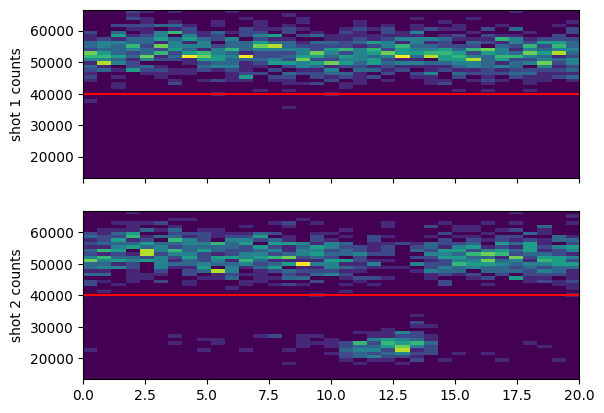

In [18]:
compare = True # compare multiple files in the same retention and loading plots

# blow-away is working but ther's some kind of bug such that the t_blowaway variable seems to be ignored. 
file_indices = {
    5: '', # clear axial resonance :D. 50 mVpp modulation + 595 mVdc on Rigol
    # 11: '', # radial resonance, super broad. 50 mVpp modulation + 595 mVdc on Rigol
    # 13: '', # radial resonance, better but still broad. 30 mVpp modulation + 595 mVdc on Rigol
    # 15: '', # radial resonance, still broad :D. 30 mVpp modulation + 595 mVdc on Rigol
    19: '' # radial resonance, still broad :D. 20 mVpp modulation + 595 mVdc on Rigol
} # the files to plot

 # for all of the files plotted, combine the data so we can do one fit for both dips
combined_retention = []
combined_frequencies = []

custom_xlabel = False
# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

if custom_xlabel:
    xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

showhist = True
showloading = False

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['plasma']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("carrier:",Rigol_carrier_frequency,"FM dev:",Rigol_FM_deviation)
    print("frequency_steps:",scan_sequence1)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    cutoff1=cutoff2 = 40000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    combined_retention += list(retention_array)
    combined_frequencies += list(scan_sequence1)
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [17]:
f['datasets']['scan_sequence1'][:]

array([ 30000.        ,  32058.82352941,  34117.64705882,  36176.47058824,
        38235.29411765,  40294.11764706,  42352.94117647,  44411.76470588,
        46470.58823529,  48529.41176471,  50588.23529412,  52647.05882353,
        54705.88235294,  56764.70588235,  58823.52941176,  60882.35294118,
        62941.17647059,  65000.        ,  67058.82352941,  69117.64705882,
        71176.47058824,  73235.29411765,  75294.11764706,  77352.94117647,
        79411.76470588,  81470.58823529,  83529.41176471,  85588.23529412,
        87647.05882353,  89705.88235294,  91764.70588235,  93823.52941176,
        95882.35294118,  97941.17647059, 100000.        ])

In [19]:
f['datasets']['scan_sequence1'][:]

array([280000., 283000., 286000., 289000., 292000., 295000., 298000.,
       301000., 304000., 307000., 310000., 313000., 316000., 319000.,
       322000., 325000., 328000., 331000., 334000., 337000.])

In [ ]:
# get the actual frequencies that were output by the Rigol given the frequency lists above which were converted to voltages


In [35]:
fnames = get_files_by_criteria(date_filters=["2024-06-27"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ReadRigolFrequencies"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))

        rid = file['rid'][()]
        print(f"file {i} ({f})")
    except OSError:
        print(f"oops... something wrong with {f}")
        pass # if rid wasn't in the file, its corrupt

found 0 files


In [36]:
f = h5py.File(os.path.join(results, fnames[7]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
print("carrier:",Rigol_carrier_frequency,"FM dev:",Rigol_FM_deviation)

IndexError: list index out of range

In [34]:
actual_frequencies
# requested_frequencies

array([59804.15674785, 60128.45632668, 60410.45596045, 60758.25550876,
       60997.95519746, 61275.25483733, 61580.75444058, 61881.55404993,
       62201.15363487, 62445.55331746, 62751.05292071, 63051.85253006,
       63357.35213331, 63615.8517976 , 63940.15137643, 64264.45095526,
       64527.65061344, 64828.45022279, 65086.94988708, 65350.14954526,
       65679.14911799, 65998.74870292, 66271.3483489 , 66562.74797046,
       66863.54757981, 67126.74723799, 67427.54684734, 67733.04645059,
       67991.54611488, 68292.34572423, 68597.84532747, 68898.64493682,
       69161.84459501, 69462.64420436, 69768.14380761])

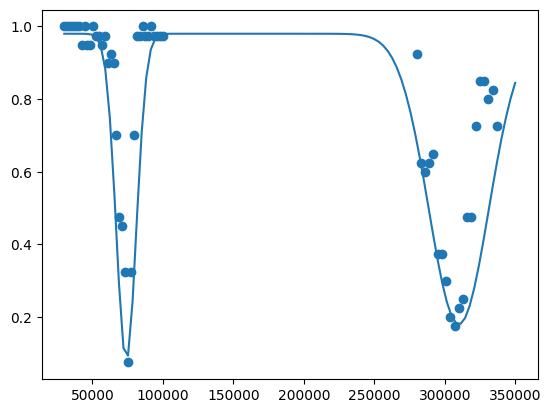

In [37]:
# important: in order to correctly fit the frequencies, 
# we need to get the actual frequencies from the Rigol based on the voltages and carrier/deviation settings

fig,ax = plt.subplots()
ax.scatter(combined_frequencies, combined_retention)

model = lambda f,r,ar,az,fr,fz,sr,sz: r - ar*np.exp(-((f-2*fr)/sr)**2) - az*np.exp(-((f-2*fz)/sz)**2)
f_list = np.linspace(30000,350000,100)
params = [0.98,0.9,0.8,37e3,155e3,10e3,30e3]
ax.plot(f_list,model(f_list,*params))

In [19]:
combined_retention

[array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.95      , 1.        , 0.95      , 0.94871795,
        1.        , 0.975     , 0.975     , 0.95      , 0.97435897,
        0.9       , 0.925     , 0.9       , 0.7       , 0.475     ,
        0.45      , 0.325     , 0.075     , 0.325     , 0.7       ,
        0.975     , 0.975     , 1.        , 0.975     , 0.975     ,
        1.        , 0.975     , 0.975     , 0.975     , 0.975     ]),
 array([0.9  , 0.8  , 0.75 , 0.775, 0.65 , 0.675, 0.625, 0.375, 0.325,
        0.175, 0.025, 0.05 , 0.025, 0.   , 0.   , 0.05 , 0.1  , 0.15 ,
        0.15 , 0.3  ])]

## January 2024

In [ ]:
def eval_str_from_h5(h5_str):
    """a stupid way to evaluate python evaluable strings I saved as ARTIQ datasets"""
    return eval(str(np.array(h5_str))[2:-1])

def get_files_by_criteria(date_filters,name_filters,condition,start_dir=results,include_path=True,print_filenames=False):
    file_list = []
    for root, dirs, files in os.walk(start_dir,topdown=False):
        for name in files:
            if True in set([x in root for x in date_filters]):
                if True in set([x in name for x in name_filters]):
                    filename = os.path.join(root, name)
                    try:
                        h5py.File(filename)
                        if condition(filename):
                            if not include_path:
                                filename = name
                                if print_filenames:
                                    print(filename)
                            file_list.append(filename)
                    except OSError:
                        print(f"skipping {filename}, which is corrupt")
    return file_list

### 2023.01.20

#### concatenate results from a batch of scans

In [51]:
fnames = get_files_by_criteria(date_filters=["2024-01-19","2024-01-20"], # only find files from these date directories
                               name_filters=["SingleAtomTrapFrequencyScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")

found 32 files


In [52]:
fnames[0][len(results):len(results)+23]

'2024-01-19\\10\\000009512'

In [53]:
 f = h5py.File(os.path.join(results, fname))

Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\10\000009512-SingleAtomTrapFrequencyScan.h5 25 != 800
Exception in C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\14\000009559-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\15\000009560-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\15\000009563-SingleAtomTrapFrequencyScan.h5 212 != 1500
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\18\000009602-SingleAtomTrapFrequencyScan.h5 25 != 100
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\18\000009603-SingleAtomTrapFrequencyScan.h5 73 != 100
Experiment aborted: 

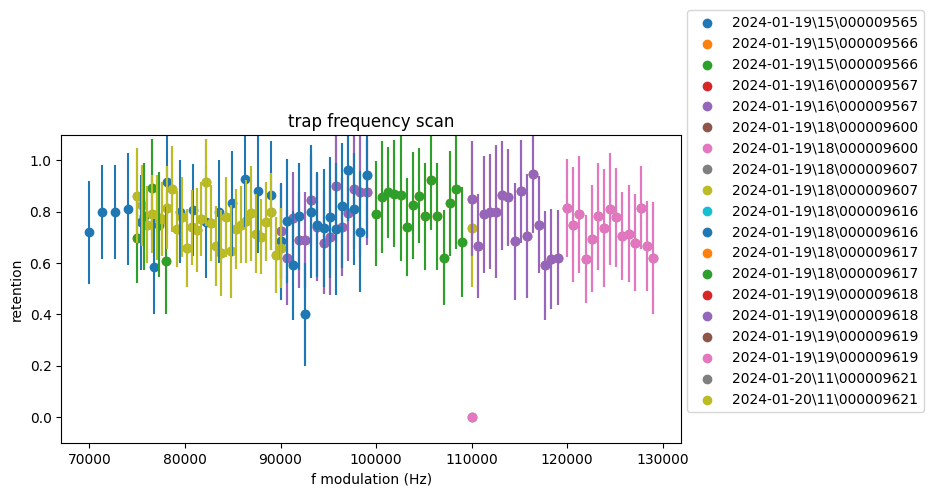

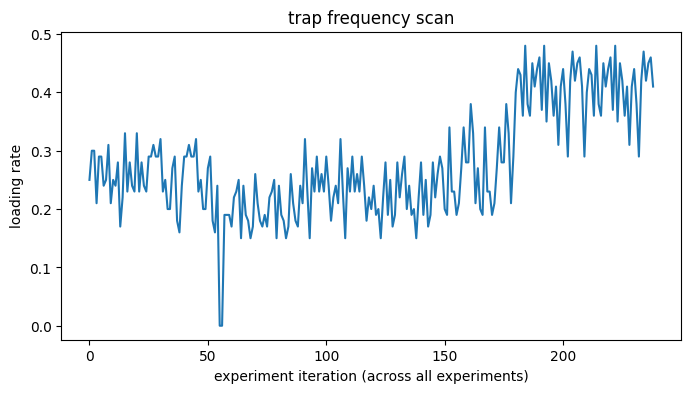

In [54]:
plot_retention = True
cutoff = 270

counts_shot1_list = []
counts_shot2_list = []
loading_rate_list = []
retention_list = []
err_list = []
f_volts_list = []

fig, ax = plt.subplots(figsize=(8,4))

for fname in fnames:
    try:
        f = h5py.File(fname) #os.path.join(results, fname))

        # assume these arguments are the same over the entire batch
        n_measurements = np.uint(f['datasets']['n_measurements'])
        
        FMdev = np.uint(f['datasets']['FM_deviation'])
        f0 = np.uint(f['datasets']['carrier_frequency'])
        f_arr = eval_str_from_h5(f['datasets']['f_modulation_sequence'])
        
        try:
            counts1 = np.array(f['datasets']['photocounts'])[1:]
            counts2 = np.array(f['datasets']['photocounts2'])[1:]

            # if this isn't true, it means there was an error during run(), e.g. the experiment was aborted
            if len(counts1) == len(f_arr)*n_measurements:
                [counts_shot1_list.append(x) for x in counts1]
                [counts_shot2_list.append(x) for x in counts2]
                f_volts = (f_arr - f0)* 5/FMdev
                [f_volts_list.append(f) for f in f_volts]

            
                retention_array = np.zeros(len(f_arr))
                loading_rate_array = np.zeros(len(f_arr))
                
                n_atoms_loaded_array = np.zeros(len(f_arr))
                
                measurements = n_measurements
                
                for i,t in enumerate(f_arr):
                    shot1 = counts1[i*measurements:(i+1)*measurements]
                    shot2 = counts2[i*measurements:(i+1)*measurements]
                    
                    atoms_loaded = [x > cutoff for x in shot1]
                    n_atoms_loaded = sum(atoms_loaded)
                    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
                    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
                    retention_array[i] = retention_fraction
                    loading_rate_array[i] = n_atoms_loaded/n_measurements
                    n_atoms_loaded_array[i] = n_atoms_loaded

                [retention_list.append(x) for x in retention_array]
                [loading_rate_list.append(x) for x in loading_rate_array]
                
                err_array = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
                [err_list.append(x) for x in err_array]

                if plot_retention:
                    ax.scatter(f_arr, retention_array, label=fname[len(results):len(results)+23])#,color='r')
                    # t_pts = np.linspace(t_arr[0],t_arr[-1],100)
                    ax.errorbar(f_arr,retention_array, err_array, ls='none')#,color='r')
            else:
                print("Experiment aborted:",fname,len(counts1),"!=",len(f_arr)*n_measurements)
        
        except KeyError as e:
            print("Exception in", fname,",",e)
    
    except OSError:
        print(fname, "is corrupt :/")
   
counts_shot1 = np.array(counts_shot1_list)
counts_shot2 = np.array(counts_shot1_list)
loading_rate = np.array(loading_rate_list)

# f_volts = np.array(f_volts_list)
# f_abs = (f_volts+10)*(2*FMdev/10)+f0

if plot_retention:
    ax.set_title('trap frequency scan')
    ax.set_ylabel("retention")
    ax.set_xlabel("f modulation (Hz)")
    ax.set_ylim((-0.1,1.1))
    ax.legend(loc=(1.01,0.1))
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    
    ax.plot(loading_rate)
    ax.set_title('trap frequency scan')
    ax.set_ylabel("loading rate")
    ax.set_xlabel("experiment iteration (across all experiments)")
    plt.show()

(array([  4.,  11.,  21.,  49., 115., 228., 365., 482., 656., 607., 831.,
        880., 816., 733., 632., 519., 416., 302., 220., 137., 154.,  81.,
         36.,  49.,  53.,  56.,  75.,  92., 115., 112., 170., 179., 204.,
        253., 229., 236., 194., 185., 164., 112., 103.,  65.,  52.,  48.,
         19.,  14.,  11.,   7.,   5.,   5.]),
 array([175. , 179.9, 184.8, 189.7, 194.6, 199.5, 204.4, 209.3, 214.2,
        219.1, 224. , 228.9, 233.8, 238.7, 243.6, 248.5, 253.4, 258.3,
        263.2, 268.1, 273. , 277.9, 282.8, 287.7, 292.6, 297.5, 302.4,
        307.3, 312.2, 317.1, 322. , 326.9, 331.8, 336.7, 341.6, 346.5,
        351.4, 356.3, 361.2, 366.1, 371. , 375.9, 380.8, 385.7, 390.6,
        395.5, 400.4, 405.3, 410.2, 415.1, 420. ]),
 <BarContainer object of 50 artists>)

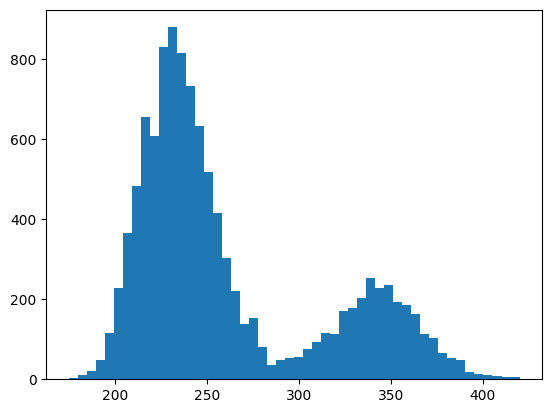

In [50]:
plt.hist(counts_shot1_list,bins=50)

## December 2023

### 2023.12.07

#### concatenate results from a batch of scans

In [ ]:
# i made a mistake when entering the frequency modulation list. 
# i entered absolute frequency steps rather than modulation steps. the first few scans are in the valid
# voltage range but I need to calculate the actual frequencies that the voltages correspond to for these.

# a batch of scans from 70 kHz to ~ 130 kHz with ~700 Hz steps looking for the axial resonance.
# fnames = ["2023-12-06"+x for x in [
#            "\\17\\000008284-SingleAtomTrapFrequencyScan.h5",
#            "\\17\\000008285-SingleAtomTrapFrequencyScan.h5",
#            "\\18\\000008286-SingleAtomTrapFrequencyScan.h5",
#            "\\18\\000008287-SingleAtomTrapFrequencyScan.h5", # everything below this has an invalid voltage for the Rigol.
#            "\\19\\000008288-SingleAtomTrapFrequencyScan.h5",
#            "\\19\\000008289-SingleAtomTrapFrequencyScan.h5",
#            "\\20\\000008290-SingleAtomTrapFrequencyScan.h5",
#            "\\21\\000008291-SingleAtomTrapFrequencyScan.h5"
#            "\\21\\000008292-SingleAtomTrapFrequencyScan.h5", # invalid DAC voltage toward the end
#            "\\22\\000008293-SingleAtomTrapFrequencyScan.h5", # invalid DAC voltage
#           ]]

In [140]:
fnames = ["2023-12-07"+x for x in [
            "\\14\\000008373-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008374-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008375-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008376-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008377-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008380-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008382-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008383-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008395-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008398-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008402-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008410-SingleAtomTrapFrequencyScan.h5",
            "\\16\\000008423-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008425-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008426-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008427-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008428-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008429-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008430-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008431-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008432-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008433-SingleAtomTrapFrequencyScan.h5",
            "\\19\\000008434-SingleAtomTrapFrequencyScan.h5",
            "\\19\\000008435-SingleAtomTrapFrequencyScan.h5"]
]

fnames += ["2023-12-11"+x for x in [
            "\\18\\000008558-SingleAtomTrapFrequencyScan.h5",
            "\\18\\000008559-SingleAtomTrapFrequencyScan.h5",
            "\\18\\000008560-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008561-SingleAtomTrapFrequencyScan.h5" # possible resonance. need finer scan
        ]
]

fnames += ["2023-12-12"+x for x in [
            "\\11\\000008567-SingleAtomTrapFrequencyScan.h5"]
]

Exception in 2023-12-07\14\000008375-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: 2023-12-07\14\000008377-SingleAtomTrapFrequencyScan.h5 159 != 840
Experiment aborted: 2023-12-07\15\000008380-SingleAtomTrapFrequencyScan.h5 13 != 840
Exception in 2023-12-07\15\000008382-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008383-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008395-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008398-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: 2023-12-07\15\000008402-SingleAtomTrapFrequencyScan.h5 26 != 840
Exception in 2023-1

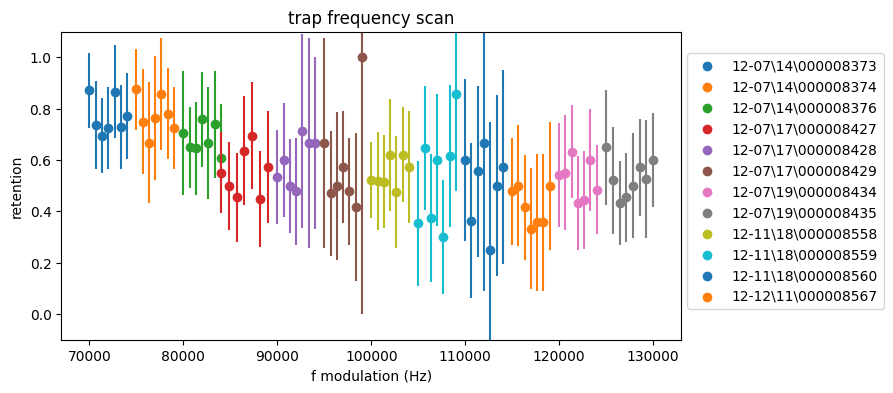

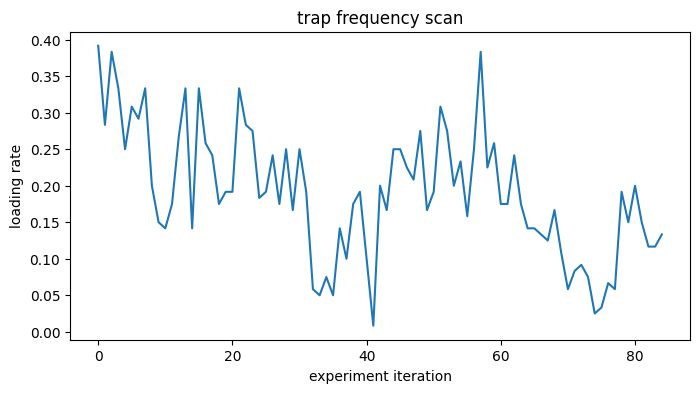

In [141]:
plot_retention = True
cutoff = 180

counts_shot1_list = []
counts_shot2_list = []
loading_rate_list = []
retention_list = []
err_list = []
f_volts_list = []

fig, ax = plt.subplots(figsize=(8,4))

for fname in fnames:
    try:
        f = h5py.File(os.path.join(results, fname))

        # assume these arguments are the same over the entire batch
        n_measurements = np.uint(f['datasets']['n_measurements'])
        
        FMdev = np.uint(f['datasets']['FM_deviation'])
        f0 = np.uint(f['datasets']['carrier_frequency'])
        f_arr = eval_str_from_h5(f['datasets']['f_modulation'])
        
        try:
            counts1 = np.array(f['datasets']['photocounts'])[1:]
            counts2 = np.array(f['datasets']['photocounts2'])[1:]

            # if this isn't true, it means there was an error during run(), e.g. the experiment was aborted
            if len(counts1) == len(f_arr)*n_measurements:
                [counts_shot1_list.append(x) for x in counts1]
                [counts_shot2_list.append(x) for x in counts2]
                f_volts = (f_arr - f0)* 5/FMdev
                [f_volts_list.append(f) for f in f_volts]

            
                retention_array = np.zeros(len(f_arr))
                loading_rate_array = np.zeros(len(f_arr))
                
                n_atoms_loaded_array = np.zeros(len(f_arr))
                
                measurements = n_measurements
                
                for i,t in enumerate(f_arr):
                    shot1 = counts1[i*measurements:(i+1)*measurements]
                    shot2 = counts2[i*measurements:(i+1)*measurements]
                    
                    atoms_loaded = [x > cutoff for x in shot1]
                    n_atoms_loaded = sum(atoms_loaded)
                    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
                    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
                    retention_array[i] = retention_fraction
                    loading_rate_array[i] = n_atoms_loaded/n_measurements
                    n_atoms_loaded_array[i] = n_atoms_loaded

                [retention_list.append(x) for x in retention_array]
                [loading_rate_list.append(x) for x in loading_rate_array]
                
                err_array = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
                [err_list.append(x) for x in err_array]

                if plot_retention:
                    ax.scatter(f_arr, retention_array, label=fname[5:23])#,color='r')
                    # t_pts = np.linspace(t_arr[0],t_arr[-1],100)
                    ax.errorbar(f_arr,retention_array, err_array, ls='none')#,color='r')
            else:
                print("Experiment aborted:",fname,len(counts1),"!=",len(f_arr)*n_measurements)
        
        except KeyError as e:
            print("Exception in", fname,",",e)
    
    except OSError:
        print(fname, "is corrupt :/")
   
counts_shot1 = np.array(counts_shot1_list)
counts_shot2 = np.array(counts_shot1_list)
loading_rate = np.array(loading_rate_list)

f_volts = np.array(f_volts_list)
f_abs = (f_volts+10)*(2*FMdev/10)+f0

if plot_retention:
    # plt.title('trap frequency scan')
    # plt.ylabel("retention")
    # plt.xlabel("f modulation (Hz)")
    # plt.ylim((-0.1,1.1))
    # plt.legend(loc=(1.1,0.5))
    # plt.show()

    ax.set_title('trap frequency scan')
    ax.set_ylabel("retention")
    ax.set_xlabel("f modulation (Hz)")
    ax.set_ylim((-0.1,1.1))
    ax.legend(loc=(1.01,0.1))
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    
    ax.plot(loading_rate)
    ax.set_title('trap frequency scan')
    ax.set_ylabel("loading rate")
    ax.set_xlabel("experiment iteration")
    plt.show()

Text(0.5, 0, 'f modulation (Hz)')

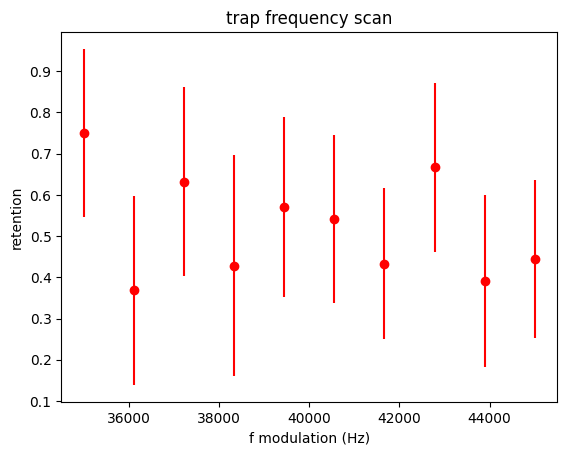

In [54]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = 180
retention_array = np.zeros(len(f_arr))
loading_rate_array = np.zeros(len(f_arr))

n_atoms_loaded_array = np.zeros(len(f_arr))

measurements = n_measurements #if not control_experiment else n_measurements//2

for i,t in enumerate(f_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(f_arr, retention_array, label='data',color='r')
# t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('trap frequency scan')
plt.errorbar(f_arr,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("f modulation (Hz)")

### 2023.12.05

In [51]:
# the first trap parametric heating frequency scan
fname = "2023-12-05\\18\\000008249-SingleAtomTrapFrequencyScan.h5" # file is corrupt

# this is the data exported from the photocount shot 1 and 2 applets
csv1 = "2023-12-05\\18\\frequency_scan_shot1.csv" # I exported the photocounts from shot 1 and shot 2
csv2 = "2023-12-05\\18\\frequency_scan_shot2.csv"

fname = "2023-12-06\\10\\000008265-SingleAtomTrapFrequencyScan.h5" # bad snr
fname = "2023-12-06\\10\\000008275-SingleAtomTrapFrequencyScan.h5" # bad snr


f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [48]:
# data = []
# file = csv1
# with open(os.path.join(results, file)) as f:
#     reader = csv.reader(f)
#     header = reader.__next__()
#     for row in reader:
#         data.append([float(x) for x in row][1])
# counts_shot1 = np.array(data)

# data = []
# file = csv2
# with open(os.path.join(results, file)) as f:
#     reader = csv.reader(f)
#     header = reader.__next__()
#     for row in reader:
#         data.append([float(x) for x in row][1])
# counts_shot2 = np.array(data)

# f_arr = np.linspace(5.0, 20.0, 10) # kHz
# n_measurements =200

In [52]:
n_measurements = np.uint(f['datasets']['n_measurements'])

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

f_arr = eval_str_from_h5(f['datasets']['f_modulation'])

Text(0.5, 0, 'f modulation (Hz)')

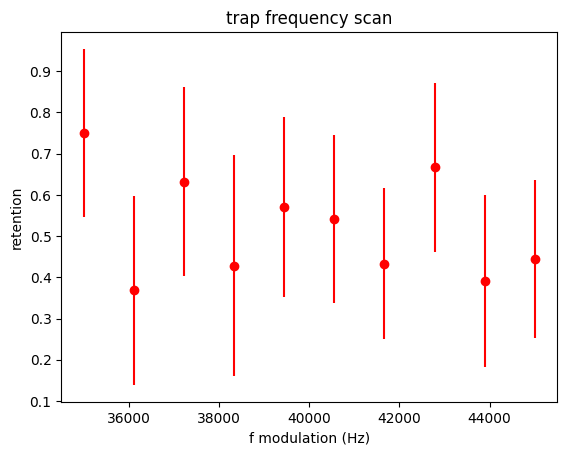

In [54]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*len(f_arr)
retention_array = np.zeros(len(f_arr))
loading_rate_array = np.zeros(len(f_arr))

n_atoms_loaded_array = np.zeros(len(f_arr))

measurements = n_measurements #if not control_experiment else n_measurements//2

for i,t in enumerate(f_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

# tau = 5 # us
# tpts = np.linspace(t_arr[0],t_arr[-1],100)/us
# plt.plot(tpts, 0.9*np.exp(-tpts/tau),color='r',linestyle='--',label=r'$\tau=$'+f'{tau}'+r'$\mu$s')

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(f_arr, retention_array, label='data',color='r')
# t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('trap frequency scan')
plt.errorbar(f_arr,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("f modulation (Hz)")